In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('./kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [4]:
data = pd.read_csv("./archive/fer2013.csv")
data.shape

(35887, 3)

In [5]:
x_data = data['pixels']
y_data = data['emotion']

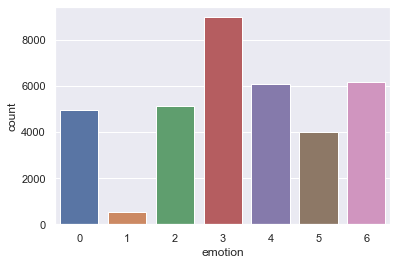

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [7]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [8]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [9]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    67 45 34 13 14 66 90 76 121 171 189 203 220 22...
62919    88 78 92 70 85 79 77 82 58 63 85 45 43 38 37 3...
62920    25 25 25 32 32 26 19 18 19 22 20 19 18 20 20 2...
62921    255 255 255 255 254 254 255 251 234 220 225 22...
62922    239 239 238 237 236 238 220 162 94 77 39 54 60...
Length: 62923, dtype: object

In [10]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255

In [11]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)
print(x_train.shape," ",y_train.shape)

(56630, 2304)   (56630, 1)


In [13]:
y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

In [14]:
model = keras.Sequential([
    Input(x_train.shape[1]),
    Dense(2048, activation = 'relu'),
    BatchNormalization(axis = 1),
    Dense(1024, activation = 'relu'),
    BatchNormalization(axis = 1),
    Dense(512, activation = 'relu'),
    BatchNormalization(axis = 1),
    Dense(256, activation = 'relu'),
    BatchNormalization(axis = 1),
    Dense(7, activation = 'sigmoid')
])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              4720640   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2

In [15]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [16]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [1]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100)


KeyboardInterrupt



In [19]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 1s 7ms/step - loss: 2.4781 - accuracy: 0.2848
Accuracy of our model on validation data :  28.476083278656006 %


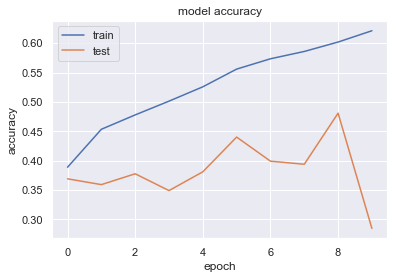

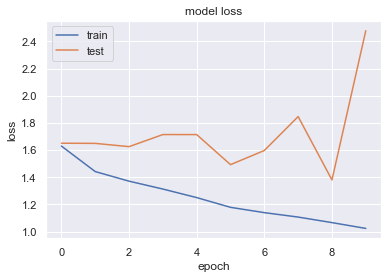

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
predictions = model.predict(x_test)
y_pred = []

for p in predictions:
    y_pred.append(np.argmax(p))
y_pred[:10]

[0, 5, 0, 5, 6, 6, 0, 4, 0, 3]

In [22]:
y_actual = []

for a in y_test:
    y_actual.append(np.argmax(a))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.74      0.31       935
           1       0.96      0.06      0.12       895
           2       0.33      0.11      0.16       880
           3       0.39      0.36      0.38       906
           4       0.30      0.11      0.16       888
           5       0.43      0.41      0.42       869
           6       0.39      0.18      0.25       920

    accuracy                           0.28      6293
   macro avg       0.43      0.28      0.26      6293
weighted avg       0.43      0.28      0.26      6293



Text(66.5, 0.5, 'Truth')

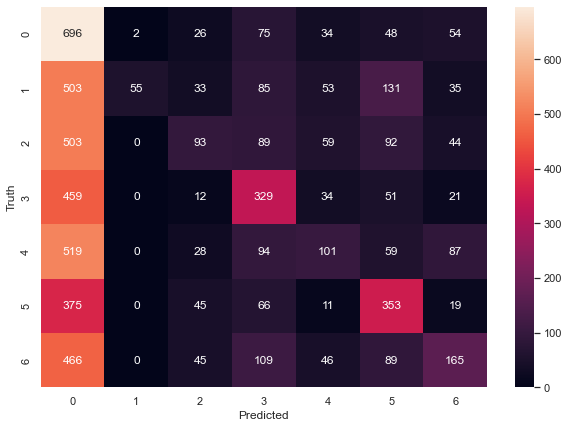

In [24]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_pred)

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')